In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [122]:
import os
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS = 55

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, lable_batch in dataset.take(1):
    print(image_batch.shape)
    print(lable_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 2 2 1 0 1 2 1 1 1]


In [7]:
# for image_batch, lable_batch in dataset.take(1):
#     print(image_batch[0])

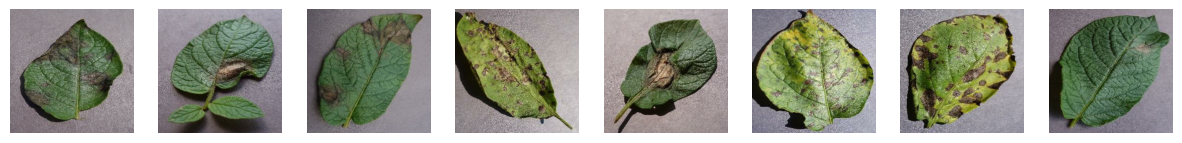

In [8]:
plt.figure(figsize=(15,4))
for image_batch, lable_batch in dataset.take(1):
    for i in range(8):
        plt.subplot(1,8,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        # plt.title(class_names[lable_batch[i]])
        plt.axis('off')

# Test train and split

In [13]:
def get_dataset_partition_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    test_size = int(test_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size+test_size)

    return train_ds, test_ds, val_ds

In [14]:
train_ds, test_ds, val_ds = get_dataset_partition_tf(dataset)
print(len(train_ds), len(test_ds), len(val_ds))

54 6 8


In [15]:
train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Resize, Rescaling, Flip and Rotaiion

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE), # We did resizing because if yopu are train a DS then if a image is different size them other, this will resize that image. In short it will make sure that every image should be same size.
    layers.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_andvertical"),
    layers.RandomRotation(0.2)
])

# Build model Architecture

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Running the model

In [21]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.5527 - loss: 0.9049 - val_accuracy: 0.6445 - val_loss: 0.7775
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7341 - loss: 0.5499 - val_accuracy: 0.8750 - val_loss: 0.2780
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8971 - loss: 0.2496 - val_accuracy: 0.8621 - val_loss: 0.3217
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9050 - loss: 0.2374 - val_accuracy: 0.9353 - val_loss: 0.1768
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9356 - loss: 0.1701 - val_accuracy: 0.8633 - val_loss: 0.3375
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9624 - loss: 0.0907 - val_accuracy: 0.9609 - val_loss: 0.1365
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9629 - loss: 0.0998 - val_accuracy: 0.9297 - val_loss: 0.2023
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9755 - loss: 0.0918 - val_accuracy: 0.9336 - v

In [22]:
scores = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 855ms/step - accuracy: 0.7859 - loss: 0.7790


In [23]:
scores

[0.8604105114936829, 0.7916666865348816]

In [25]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot predctions

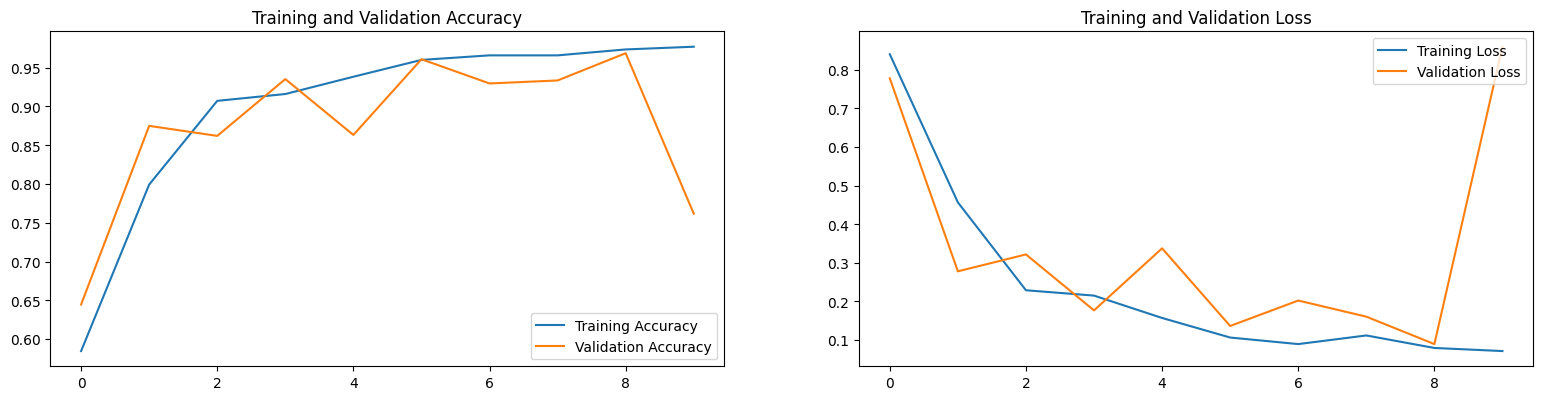

In [67]:
plt.figure(figsize=(40,20))
plt.subplot(4,4,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(4,4,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [86]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


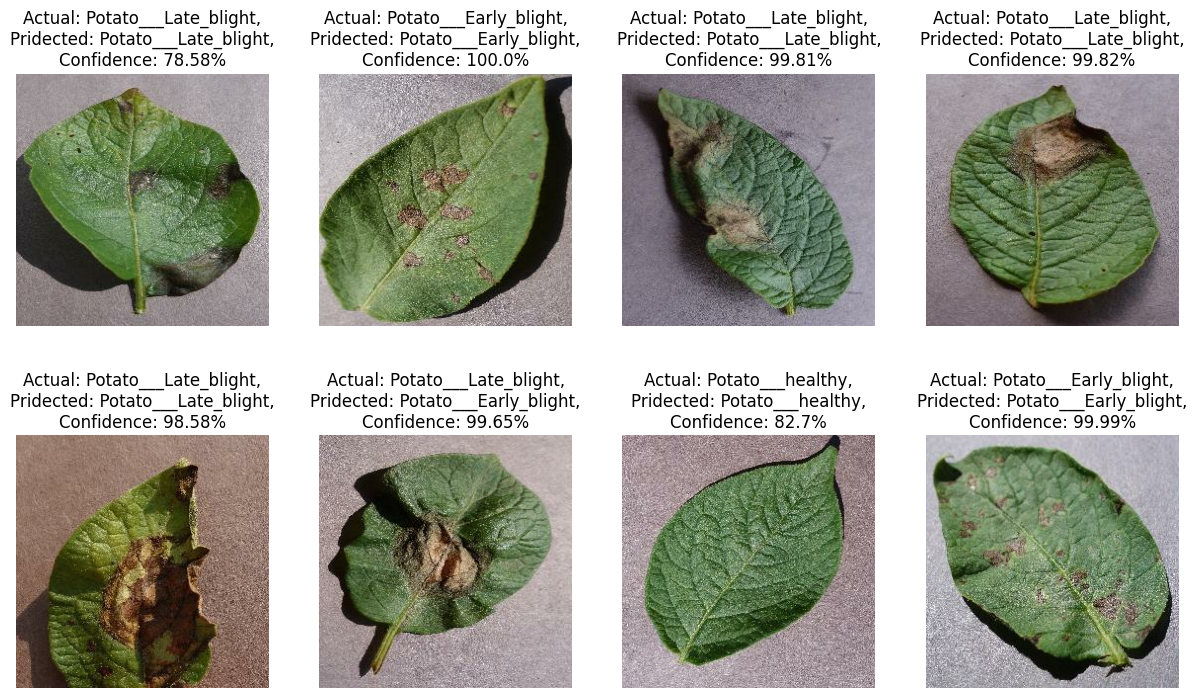

In [105]:
plt.figure(figsize=(15,18))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'Actual: {actual_class},\nPridected: {predicted_class},\nConfidence: {confidence}%')
        
        plt.axis('off')

# Export model

In [131]:
# model_version=1
base_path = os.makedirs('models', exist_ok=True)
model_version = max([int(str(i).replace('V_', '')) for i in os.listdir('models') + [0]]) + 1
path = os.makedirs(f'models/V_{model_version}', exist_ok=True)
model.save(f"models/V_{model_version}/model_{model_version}.keras")